In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2023-12-08 13:12:40.838670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 13:12:40.838777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 13:12:41.016003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 13:12:41.361441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 13:12:44.104345: W tensorflow/compiler/tf2

### Help functions

In [2]:
def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies, test_loss, test_accuracy):
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(f'Loss (test loss = {test_loss:.4f})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.title(f'Accuracy (test accuracy = {test_accuracy:.4f})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.legend()
    plt.show()

# Data

Images are saved in separate folders for each flower type

In [3]:
# list of labels
labels_list = ['sunflower', 'tulip', 'daisy', 'rose', 'dandelion']

# directories where data is saved
dir_list = ['./data/sunflower/', './data/tulip/', './data/daisy/', './data/rose/', './data/dandelion/']

Create list X of images as arrays and list y with labels (0-4, with index corresponding to labels_list)

In [4]:
X = []
y = []

for dir in dir_list:
    for filename in os.listdir(dir):
        path = os.path.join(dir, filename)
        img = Image.open(path).resize((150,150)) # read in image and resize
        img_array = tf.keras.utils.img_to_array(img) # trasform into array
        X.append(img_array)
        y.append(dir_list.index(dir))

X: make array and normalize all 3 channels\
y: make array and apply one-hot encoding into 5 categories

In [5]:
X_array = np.array(X) / 255.0

y_array = np.array(y)   
y_array = to_categorical(y_array, len(labels_list))

X_array.shape, y_array.shape

((4317, 150, 150, 3), (4317, 5))

Split data into train, val and test (60:20:20)

In [6]:
X_trainval, X_test, y_trainval, y_test =train_test_split(X_array, y_array, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val =train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((2589, 150, 150, 3),
 (864, 150, 150, 3),
 (864, 150, 150, 3),
 (2589, 5),
 (864, 5),
 (864, 5))

# Define basic model

In [7]:
model_base = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_base.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 175232)            0

In [8]:
history = model_base.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()

2023-12-08 13:13:12.823999: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 699030000 exceeds 10% of free system memory.


Epoch 1/10
81/81 [==============================] - ETA: 0s - loss: 1.3595 - accuracy: 0.4345

2023-12-08 13:14:31.947837: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 233280000 exceeds 10% of free system memory.


81/81 [==============================] - 85s 1s/step - loss: 1.3595 - accuracy: 0.4345 - val_loss: 1.1787 - val_accuracy: 0.5243
Epoch 2/10
81/81 [==============================] - 88s 1s/step - loss: 1.0369 - accuracy: 0.5948 - val_loss: 1.0534 - val_accuracy: 0.5833
Epoch 3/10
81/81 [==============================] - 89s 1s/step - loss: 0.8963 - accuracy: 0.6613 - val_loss: 1.0008 - val_accuracy: 0.5914
Epoch 4/10
81/81 [==============================] - 89s 1s/step - loss: 0.6820 - accuracy: 0.7451 - val_loss: 1.0705 - val_accuracy: 0.5822
Epoch 5/10
81/81 [==============================] - 87s 1s/step - loss: 0.4316 - accuracy: 0.8509 - val_loss: 1.2926 - val_accuracy: 0.6076
Epoch 6/10
81/81 [==============================] - 86s 1s/step - loss: 0.2213 - accuracy: 0.9312 - val_loss: 1.4907 - val_accuracy: 0.6076
Epoch 7/10
81/81 [==============================] - 87s 1s/step - loss: 0.1168 - accuracy: 0.9633 - val_loss: 1.8988 - val_accuracy: 0.5787
Epoch 8/10
81/81 [=============

In [9]:
test_loss, test_accuracy = model_base.evaluate(X_test, y_test, verbose=2)

2023-12-08 13:27:44.560114: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 233280000 exceeds 10% of free system memory.


27/27 - 6s - loss: 2.6301 - accuracy: 0.5694 - 6s/epoch - 237ms/step


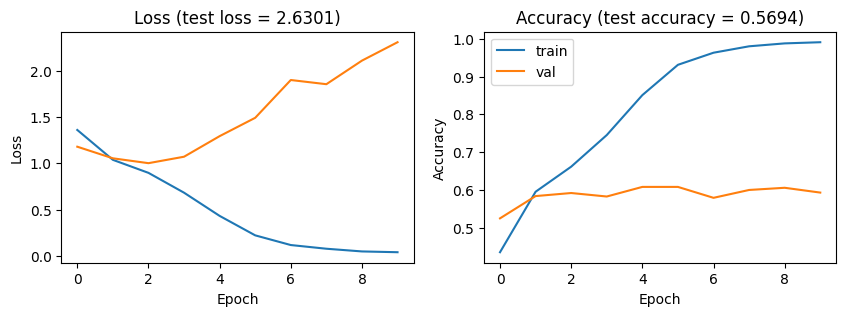

In [10]:
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

Basic model is overfitting and has poor performance on test data. Regularization techniques such as early stopping, dropouts, L2, fewer kernels and data augumentation could be applied.

Model architecture is CNN with input size corresponding to X data. Increesing number of kernels through out the network. Conv2D layers with the go to ReLU function and zeropadding. Maxpooling is applied. Final layer is activated with softmax since it is a multi-classification problem with output 5. Loss function is 'categorical_crossentropy' which is suiable for multiclassification problem. \
Data was resized and normalized. One-shot classification was used to create output vectors for 5 categories.\
Model performance was evaluated by plotting training and validation losses and accuracies as function of epoches.\
Further improvments could be atcheved by for example data augumentation to increase amount of data or more thorough data pretreatment.